# Tanpa Jarak

In [2]:
import cv2
import numpy as np
from ultralytics import YOLO
from IPython.display import display, clear_output
from PIL import Image
import math

In [ ]:
def calculate_angle(a, b, c):
    a, b, c = np.array(a), np.array(b), np.array(c)
    ba, bc = a - b, c - b
    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc) + 1e-6)
    return np.degrees(np.arccos(np.clip(cosine_angle, -1.0, 1.0)))

# Ganti dengan IP address ESP32-CAM kamu
ESP32_URL = "http://10.16.120.169:81/stream"

cap = cv2.VideoCapture(0)
model = YOLO("yolov8n-pose.pt")

pushup_count = 0
is_down = False

try:
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        results = model.predict(frame, conf=0.5, verbose=False)
        keypoints = results[0].keypoints

        if keypoints is not None and len(keypoints.xy) > 0:
            kp = keypoints.xy[0]

            try:
                # Kiri: shoulder (5), elbow (7), wrist (9)
                # Kanan: shoulder (6), elbow (8), wrist (10)
                ids = [5, 6, 7, 8, 9, 10]
                points = [tuple(kp[i].tolist()) for i in ids]
                if all(p[0] > 0 and p[1] > 0 for p in points):  # pastikan semua point valid
                    l_shoulder, r_shoulder, l_elbow, r_elbow, l_wrist, r_wrist = points

                    angle_left = calculate_angle(l_shoulder, l_elbow, l_wrist)
                    angle_right = calculate_angle(r_shoulder, r_elbow, r_wrist)

                    # Gambar garis & sudut
                    for (a, b, c) in [(l_shoulder, l_elbow, l_wrist), (r_shoulder, r_elbow, r_wrist)]:
                        cv2.line(frame, tuple(map(int, a)), tuple(map(int, b)), (255, 255, 0), 2)
                        cv2.line(frame, tuple(map(int, c)), tuple(map(int, b)), (255, 255, 0), 2)
                        for pt in [a, b, c]:
                            cv2.circle(frame, tuple(map(int, pt)), 6, (0, 255, 0), -1)

                    # Tampilkan nilai sudut
                    cv2.putText(frame, f"L: {int(angle_left)}", tuple(map(int, l_elbow)),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 255), 2)
                    cv2.putText(frame, f"R: {int(angle_right)}", tuple(map(int, r_elbow)),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 255), 2)

                    # Cek apakah kedua siku dalam posisi "down"
                    if 90 <= angle_left <= 120 and 90 <= angle_right <= 120:
                        if not is_down:
                            is_down = True  # Turun baru
                    elif angle_left > 150 and angle_right > 150:
                        if is_down:  # Naik kembali dari posisi "down"
                            pushup_count += 1
                            is_down = False

            except Exception as e:
                print("Tracking gagal:", e)

        # Info push-up
        cv2.putText(frame, f"Push-ups: {pushup_count}", (20, 50),
                    cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 0, 255), 2)

        # Tampilkan di notebook
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        img = Image.fromarray(frame_rgb)
        clear_output(wait=True)
        display(img)

except KeyboardInterrupt:
    print("Tracking dihentikan manual.")


finally:
    cap.release()
    print(f"Total push-up kamu: {pushup_count}")


Tracking dihentikan manual.
Total push-up kamu: 2


# Dengan jarak

In [1]:
import cv2
import numpy as np
from ultralytics import YOLO
from IPython.display import display, clear_output
from PIL import Image
import math
from ubidots import ApiClient

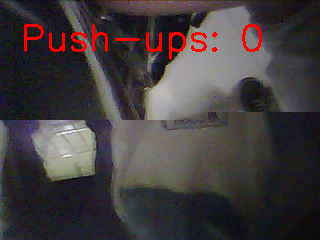

Total push-up kamu: 0


In [4]:
def calculate_angle(a, b, c):
    a, b, c = np.array(a), np.array(b), np.array(c)
    ba, bc = a - b, c - b
    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc) + 1e-6)
    return np.degrees(np.arccos(np.clip(cosine_angle, -1.0, 1.0)))

# UBIDOTS_TOKEN = "BBFF-xxxxxx"  # Ganti dengan token Anda
# VARIABLE_ID = "64f5xxxxxx"     # Ganti dengan ID variabel
# api = ApiClient(token=UBIDOTS_TOKEN)
# pushup_var = api.get_variable(VARIABLE_ID)

esp32_url ='http://10.16.120.169:81/stream'  # Ganti dengan IP address ESP32-CAM Anda
model = YOLO("yolov8n-pose.pt")
cap = cv2.VideoCapture(esp32_url)

pushup_count = 0
is_down = False

try:
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        results = model.predict(frame, conf=0.5, verbose=False)
        keypoints = results[0].keypoints

        if keypoints is not None and len(keypoints.xy) > 0:
            kp = keypoints.xy[0]

            try:
                # Ambil titik: shoulder (5/6), elbow (7/8), wrist (9/10)
                ids = [5, 6, 7, 8, 9, 10]
                points = [tuple(kp[i].tolist()) for i in ids]
                if all(p[0] > 0 and p[1] > 0 for p in points):  # pastikan semua point valid
                    l_shoulder, r_shoulder, l_elbow, r_elbow, l_wrist, r_wrist = points

                    angle_left = calculate_angle(l_shoulder, l_elbow, l_wrist)
                    angle_right = calculate_angle(r_shoulder, r_elbow, r_wrist)

                    # Hitung jarak antar bahu sebagai estimasi jarak pengguna
                    shoulder_distance = np.linalg.norm(np.array(l_shoulder) - np.array(r_shoulder))
                    
                    # Mapping ke rentang sudut adaptif (linear scaling)
                    scale = np.clip((shoulder_distance - 120) / 80, 0, 1)  # skala antara 0 dan 1
                    down_min = int(75 + (10 * scale))
                    down_max = int(105 - (10 * scale))

                    # Debug: tampilkan rentang
                    cv2.putText(frame, f"Range: {down_min}-{down_max}", (20, 100),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 0), 2)

                    # Gambar garis dan titik
                    for (a, b, c) in [(l_shoulder, l_elbow, l_wrist), (r_shoulder, r_elbow, r_wrist)]:
                        cv2.line(frame, tuple(map(int, a)), tuple(map(int, b)), (255, 255, 0), 2)
                        cv2.line(frame, tuple(map(int, c)), tuple(map(int, b)), (255, 255, 0), 2)
                        for pt in [a, b, c]:
                            cv2.circle(frame, tuple(map(int, pt)), 6, (0, 255, 0), -1)

                    # Tampilkan nilai sudut
                    cv2.putText(frame, f"L: {int(angle_left)}", tuple(map(int, l_elbow)),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 255), 2)
                    cv2.putText(frame, f"R: {int(angle_right)}", tuple(map(int, r_elbow)),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 255), 2)

                    # Deteksi posisi "down" adaptif
                    if down_min <= angle_left <= down_max and down_min <= angle_right <= down_max:
                        if not is_down:
                            is_down = True
                    elif angle_left > 150 and angle_right > 150:
                        if is_down:
                            pushup_count += 1
                            is_down = False

            except Exception as e:
                print("Tracking gagal:", e)

        # Info push-up
        cv2.putText(frame, f"Push-ups: {pushup_count}", (20, 50),
                    cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 0, 255), 2)

        # Tampilkan di notebook
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        img = Image.fromarray(frame_rgb)
        clear_output(wait=True)
        display(img)

except KeyboardInterrupt:
    print("Tracking dihentikan manual.")

finally:
    cap.release()
    print(f"Total push-up kamu: {pushup_count}")


In [4]:
def calculate_angle(a, b, c):
    a, b, c = np.array(a), np.array(b), np.array(c)
    ba, bc = a - b, c - b
    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc) + 1e-6)
    return np.degrees(np.arccos(np.clip(cosine_angle, -1.0, 1.0)))

UBIDOTS_TOKEN = "BBUS-DHs4IfDYDWUWHfHRTnZNSL9wuXiOR9"  # Ganti dengan token Anda
VARIABLE_ID = "67fa31aaa395d7300baf1cd8"     # Ganti dengan ID variabel
api = ApiClient(token=UBIDOTS_TOKEN)
pushup_var = api.get_variable(VARIABLE_ID)

model = YOLO("yolov8n-pose.pt")
cap = cv2.VideoCapture(0)

pushup_count = 0
is_down = False

try:
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        results = model.predict(frame, conf=0.5, verbose=False)
        keypoints = results[0].keypoints

        if keypoints is not None and len(keypoints.xy) > 0:
            kp = keypoints.xy[0]

            try:
                # Ambil titik: shoulder (5/6), elbow (7/8), wrist (9/10)
                ids = [5, 6, 7, 8, 9, 10]
                points = [tuple(kp[i].tolist()) for i in ids]
                if all(p[0] > 0 and p[1] > 0 for p in points):  # pastikan semua point valid
                    l_shoulder, r_shoulder, l_elbow, r_elbow, l_wrist, r_wrist = points

                    angle_left = calculate_angle(l_shoulder, l_elbow, l_wrist)
                    angle_right = calculate_angle(r_shoulder, r_elbow, r_wrist)

                    # Hitung jarak antar bahu sebagai estimasi jarak pengguna
                    shoulder_distance = np.linalg.norm(np.array(l_shoulder) - np.array(r_shoulder))
                    
                    # Mapping ke rentang sudut adaptif (linear scaling)
                    scale = np.clip((shoulder_distance - 120) / 80, 0, 1)  # skala antara 0 dan 1
                    down_min = int(75 + (10 * scale))
                    down_max = int(105 - (10 * scale))

                    # Debug: tampilkan rentang
                    cv2.putText(frame, f"Range: {down_min}-{down_max}", (20, 100),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 0), 2)

                    # Gambar garis dan titik
                    for (a, b, c) in [(l_shoulder, l_elbow, l_wrist), (r_shoulder, r_elbow, r_wrist)]:
                        cv2.line(frame, tuple(map(int, a)), tuple(map(int, b)), (255, 255, 0), 2)
                        cv2.line(frame, tuple(map(int, c)), tuple(map(int, b)), (255, 255, 0), 2)
                        for pt in [a, b, c]:
                            cv2.circle(frame, tuple(map(int, pt)), 6, (0, 255, 0), -1)

                    # Tampilkan nilai sudut
                    cv2.putText(frame, f"L: {int(angle_left)}", tuple(map(int, l_elbow)),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 255), 2)
                    cv2.putText(frame, f"R: {int(angle_right)}", tuple(map(int, r_elbow)),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 255), 2)

                    # Deteksi posisi "down" adaptif
                    if down_min <= angle_left <= down_max and down_min <= angle_right <= down_max:
                        if not is_down:
                            is_down = True
                    elif angle_left > 150 and angle_right > 150:
                        if is_down:
                            pushup_count += 1
                            is_down = False

                            try:
                                pushup_var.save_value({'value': pushup_count})
                                print(f"Data terkirim ke Ubidots: {pushup_count}")
                            except Exception as e:
                                print("Gagal mengirim ke Ubidots:", e)

            except Exception as e:
                print("Tracking gagal:", e)

        # Info push-up
        cv2.putText(frame, f"Push-ups: {pushup_count}", (20, 50),
                    cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 0, 255), 2)

        # Tampilkan di notebook
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        img = Image.fromarray(frame_rgb)
        clear_output(wait=True)
        display(img)

except KeyboardInterrupt:
    print("Tracking dihentikan manual.")

finally:
    cap.release()
    print(f"Total push-up kamu: {pushup_count}")


Tracking dihentikan manual.
Total push-up kamu: 3


# GUI

In [2]:
import cv2
import numpy as np
from ultralytics import YOLO
# from IPython.display import display, clear_outp0000ut
from PIL import Image
import math
from ubidots import ApiClient


In [ ]:
def calculate_angle(a, b, c):
    a, b, c = np.array(a), np.array(b), np.array(c)
    ba, bc = a - b, c - b
    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc) + 1e-6)
    return np.degrees(np.arccos(np.clip(cosine_angle, -1.0, 1.0)))

UBIDOTS_TOKEN = "BBUS-DHs4IfDYDWUWHfHRTnZNSL9wuXiOR9"  # Ganti dengan token Anda
VARIABLE_ID = "67fa31aaa395d7300baf1cd8"     # Ganti dengan ID variabel
api = ApiClient(token=UBIDOTS_TOKEN)
pushup_var = api.get_variable(VARIABLE_ID)

esp32_link = "http://10.16.120.169:81/stream" 
model = YOLO("yolov8n-pose.pt")
cap = cv2.VideoCapture(0)

pushup_count = 0
is_down = False

try:
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        results = model.predict(frame, conf=0.5, verbose=False)
        keypoints = results[0].keypoints

        if keypoints is not None and len(keypoints.xy) > 0:
            kp = keypoints.xy[0]

            try:
                # Ambil titik: shoulder (5/6), elbow (7/8), wrist (9/10)
                ids = [5, 6, 7, 8, 9, 10]
                points = [tuple(kp[i].tolist()) for i in ids]
                if all(p[0] > 0 and p[1] > 0 for p in points):  # pastikan semua point valid
                    l_shoulder, r_shoulder, l_elbow, r_elbow, l_wrist, r_wrist = points

                    angle_left = calculate_angle(l_shoulder, l_elbow, l_wrist)
                    angle_right = calculate_angle(r_shoulder, r_elbow, r_wrist)

                    # Hitung jarak antar bahu sebagai estimasi jarak pengguna
                    shoulder_distance = np.linalg.norm(np.array(l_shoulder) - np.array(r_shoulder))
                    
                    # Mapping ke rentang sudut adaptif (linear scaling)
                    scale = np.clip((shoulder_distance - 120) / 80, 0, 1)  # skala antara 0 dan 1
                    down_min = int(75 + (10 * scale))
                    down_max = int(105 - (10 * scale))

                    # Debug: tampilkan rentang
                    cv2.putText(frame, f"Range: {down_min}-{down_max}", (20, 100),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 0), 2)

                    # Gambar garis dan titik
                    for (a, b, c) in [(l_shoulder, l_elbow, l_wrist), (r_shoulder, r_elbow, r_wrist)]:
                        cv2.line(frame, tuple(map(int, a)), tuple(map(int, b)), (255, 255, 0), 2)
                        cv2.line(frame, tuple(map(int, c)), tuple(map(int, b)), (255, 255, 0), 2)
                        for pt in [a, b, c]:
                            cv2.circle(frame, tuple(map(int, pt)), 6, (0, 255, 0), -1)

                    # Tampilkan nilai sudut
                    cv2.putText(frame, f"L: {int(angle_left)}", tuple(map(int, l_elbow)),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 255), 2)
                    cv2.putText(frame, f"R: {int(angle_right)}", tuple(map(int, r_elbow)),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 255), 2)

                    # Deteksi posisi "down" adaptif
                    if down_min <= angle_left <= down_max and down_min <= angle_right <= down_max:
                        if not is_down:
                            is_down = True
                    elif angle_left > 150 and angle_right > 150:
                        if is_down:
                            pushup_count += 1
                            is_down = False

                            try:
                                pushup_var.save_value({'value': pushup_count})
                                print(f"Data terkirim ke Ubidots: {pushup_count}")
                            except Exception as e:
                                print("Gagal mengirim ke Ubidots:", e)

            except Exception as e:
                print("Tracking gagal:", e)

        # Info push-up
        cv2.putText(frame, f"Push-ups: {pushup_count}", (20, 50),
                    cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 0, 255), 2)

        # Tampilkan window dengan cv2.imshow()
        cv2.imshow("Push-Up Counter", frame)

        # Tekan 'q' untuk keluar
        if cv2.waitKey(1) & 0xFF == ord('q'):
                break

except KeyboardInterrupt:
    print("Tracking dihentikan manual.")

finally:
    cap.release()
    cv2.destroyAllWindows()
    print(f"Total push-up kamu: {pushup_count}")


Data terkirim ke Ubidots: 1
Data terkirim ke Ubidots: 2
Data terkirim ke Ubidots: 3
Data terkirim ke Ubidots: 4
Data terkirim ke Ubidots: 5
Data terkirim ke Ubidots: 6
Data terkirim ke Ubidots: 7
Data terkirim ke Ubidots: 8
Data terkirim ke Ubidots: 9
Data terkirim ke Ubidots: 10
Data terkirim ke Ubidots: 11
Data terkirim ke Ubidots: 12
Data terkirim ke Ubidots: 13
Data terkirim ke Ubidots: 14
Data terkirim ke Ubidots: 15
Data terkirim ke Ubidots: 16
Data terkirim ke Ubidots: 17
Data terkirim ke Ubidots: 18
Tracking gagal: index 5 is out of bounds for dimension 0 with size 0
Tracking gagal: index 5 is out of bounds for dimension 0 with size 0
Tracking gagal: index 5 is out of bounds for dimension 0 with size 0
Total push-up kamu: 18


# Dengan Movenet

In [ ]:
import cv2
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
from ultralytics import YOLO
# from IPython.display import display, clear_outp0000ut
from PIL import Image
import math
from ubidots import ApiClient

def calculate_angle(a, b, c):
    a, b, c = np.array(a), np.array(b), np.array(c)
    ba, bc = a - b, c - b
    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc) + 1e-6)
    return np.degrees(np.arccos(np.clip(cosine_angle, -1.0, 1.0)))

UBIDOTS_TOKEN = "BBUS-DHs4IfDYDWUWHfHRTnZNSL9wuXiOR9"  # Ganti dengan token Anda
VARIABLE_ID = "67fa31aaa395d7300baf1cd8"     # Ganti dengan ID variabel
api = ApiClient(token=UBIDOTS_TOKEN)
pushup_var = api.get_variable(VARIABLE_ID)

esp32_link = "http://10.16.120.169:81/stream" 
model = YOLO("yolov8n-pose.pt")
cap = cv2.VideoCapture(0)

pushup_count = 0
is_down = False

try:
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        results = model.predict(frame, conf=0.5, verbose=False)
        keypoints = results[0].keypoints

        if keypoints is not None and len(keypoints.xy) > 0:
            kp = keypoints.xy[0]

            try:
                # Ambil titik: shoulder (5/6), elbow (7/8), wrist (9/10)
                ids = [5, 6, 7, 8, 9, 10]
                points = [tuple(kp[i].tolist()) for i in ids]
                if all(p[0] > 0 and p[1] > 0 for p in points):  # pastikan semua point valid
                    l_shoulder, r_shoulder, l_elbow, r_elbow, l_wrist, r_wrist = points

                    angle_left = calculate_angle(l_shoulder, l_elbow, l_wrist)
                    angle_right = calculate_angle(r_shoulder, r_elbow, r_wrist)

                    # Hitung jarak antar bahu sebagai estimasi jarak pengguna
                    shoulder_distance = np.linalg.norm(np.array(l_shoulder) - np.array(r_shoulder))
                    
                    # Mapping ke rentang sudut adaptif (linear scaling)
                    scale = np.clip((shoulder_distance - 120) / 80, 0, 1)  # skala antara 0 dan 1
                    down_min = int(75 + (10 * scale))
                    down_max = int(105 - (10 * scale))

                    # Debug: tampilkan rentang
                    cv2.putText(frame, f"Range: {down_min}-{down_max}", (20, 100),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 0), 2)

                    # Gambar garis dan titik
                    for (a, b, c) in [(l_shoulder, l_elbow, l_wrist), (r_shoulder, r_elbow, r_wrist)]:
                        cv2.line(frame, tuple(map(int, a)), tuple(map(int, b)), (255, 255, 0), 2)
                        cv2.line(frame, tuple(map(int, c)), tuple(map(int, b)), (255, 255, 0), 2)
                        for pt in [a, b, c]:
                            cv2.circle(frame, tuple(map(int, pt)), 6, (0, 255, 0), -1)

                    # Tampilkan nilai sudut
                    cv2.putText(frame, f"L: {int(angle_left)}", tuple(map(int, l_elbow)),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 255), 2)
                    cv2.putText(frame, f"R: {int(angle_right)}", tuple(map(int, r_elbow)),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 255), 2)

                    # Deteksi posisi "down" adaptif
                    if down_min <= angle_left <= down_max and down_min <= angle_right <= down_max:
                        if not is_down:
                            is_down = True
                    elif angle_left > 150 and angle_right > 150:
                        if is_down:
                            pushup_count += 1
                            is_down = False

                            try:
                                pushup_var.save_value({'value': pushup_count})
                                print(f"Data terkirim ke Ubidots: {pushup_count}")
                            except Exception as e:
                                print("Gagal mengirim ke Ubidots:", e)

            except Exception as e:
                print("Tracking gagal:", e)

        # Info push-up
        cv2.putText(frame, f"Push-ups: {pushup_count}", (20, 50),
                    cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 0, 255), 2)

        # Tampilkan di notebook
        # frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        # img = Image.fromarray(frame_rgb)
        # clear_output(wait=True)
        # display(img)

        # Tampilkan window dengan cv2.imshow()
        cv2.imshow("Push-Up Counter", frame)

        # Tekan 'q' untuk keluar
        if cv2.waitKey(1) & 0xFF == ord('q'):
                break

except KeyboardInterrupt:
    print("Tracking dihentikan manual.")

finally:
    cap.release()
    cv2.destroyAllWindows()
    print(f"Total push-up kamu: {pushup_count}")
